In [1]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest
from scipy.signal import decimate
from pyspi.calculator import Calculator
from pyspi.data import Data

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [3]:
data_path = "/Users/abry4213/data/HCP100/"

# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

# Load in the group-averaged connectome data
homotopic_mask_df = (pd.read_csv(f"{data_path}/raw_data/diffusion_MRI/aparc_HCP100_group_avg_SIFT2_mean.csv",
                               header=None, 
                               names=brain_region_info.Brain_Region)
                               .assign(Brain_Region_From=brain_region_info.Brain_Region)
                               .melt(id_vars="Brain_Region_From", var_name="Brain_Region_To", value_name="SC")
                               .assign(log_SC = lambda x: np.where(x['SC'] > 0, np.log(x['SC']), 0))
                               .query("Brain_Region_From != Brain_Region_To")
                               .assign(Base_Region_From = lambda x: x.Brain_Region_From.str.replace('ctx-lh-', ''),
                                       Base_Region_To = lambda x: x.Brain_Region_To.str.replace('ctx-lh-', ''),
                                       Hemi_From = lambda x: np.where(x.Brain_Region_From.str.contains('lh'), 'Left', 'Right'),
                                       Hemi_To = lambda x: np.where(x.Brain_Region_To.str.contains('lh'), 'Left', 'Right'))
                                .assign(Base_Region_From = lambda x: x.Base_Region_From.str.replace('ctx-rh-', ''),
                                        Base_Region_To = lambda x: x.Base_Region_To.str.replace('ctx-rh-', ''),
                                        Homotopic_Connection = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 
                                                                                  np.where(x.Brain_Region_From != x.Brain_Region_To, 1, 0), 0))
                                .pivot(index=['Brain_Region_From'], columns='Brain_Region_To', values='Homotopic_Connection')
                                # Replace NaN with 0
                                 .fillna(0)
                               
)

homotopic_SC_df = (pd.read_csv(f"{data_path}/raw_data/diffusion_MRI/aparc_HCP100_group_avg_SIFT2_mean.csv",
                               header=None, 
                               names=brain_region_info.Brain_Region)
                               .assign(Brain_Region_From=brain_region_info.Brain_Region)
                               .melt(id_vars="Brain_Region_From", var_name="Brain_Region_To", value_name="SC")
                               .assign(log_SC = lambda x: np.where(x['SC'] > 0, np.log(x['SC']), 0))
                               .query("Brain_Region_From != Brain_Region_To")
                               .assign(Base_Region_From = lambda x: x.Brain_Region_From.str.replace('ctx-lh-', ''),
                                       Base_Region_To = lambda x: x.Brain_Region_To.str.replace('ctx-lh-', ''),
                                       Hemi_From = lambda x: np.where(x.Brain_Region_From.str.contains('lh'), 'Left', 'Right'),
                                       Hemi_To = lambda x: np.where(x.Brain_Region_To.str.contains('lh'), 'Left', 'Right'))
                                .assign(Base_Region_From = lambda x: x.Base_Region_From.str.replace('ctx-rh-', ''),
                                        Base_Region_To = lambda x: x.Base_Region_To.str.replace('ctx-rh-', ''),
                                        Homotopic_Connection = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 
                                                                                  np.where(x.Brain_Region_From != x.Brain_Region_To, 1, 0), 0))
                                .pivot(index=['Brain_Region_From'], columns='Brain_Region_To', values='log_SC')
                                .fillna(0)
)

# Write to CSVs
# homotopic_mask_df.to_csv(f"../data/homotopic_mask.csv", index=False)
# homotopic_SC_df.to_csv(f"../data/Group_average_log_SC.csv", index=False)

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
# Load homotopic simulations that Chris generated
E_lesion = pd.read_csv("../data/HomotopySimsLastTry/E_lesion.csv", header=None).T
E_lesion.columns = brain_region_info.Brain_Region
# Drop first 1000 timepoints
E_lesion = E_lesion.iloc[1:]

# E_balanced
E_balanced = pd.read_csv("../data/HomotopySimsLastTry/E_balanced.csv", header=None).T
E_balanced.columns = brain_region_info.Brain_Region
# Drop first 1000 timepoints
E_balanced = E_balanced.iloc[1:]

# E_balanced_lesion
E_balanced_lesion = pd.read_csv("../data/HomotopySimsLastTry/E_balanced_lesion.csv", header=None).T
E_balanced_lesion.columns = brain_region_info.Brain_Region
# Drop first 1000 timepoints
E_balanced_lesion = E_balanced_lesion.iloc[1:]

time_series_dict = {'E_balanced': E_balanced,
                    'E_balanced_lesion': E_balanced_lesion,
                    'E_lesion': E_lesion}

In [13]:
from pyspi.calculator import Calculator

calc = Calculator(configfile="../feature_extraction/pyspi/Pearson.yaml")

# Iterate over time_series_dict and compute SPIs
SPI_results_list = []

for key, value in time_series_dict.items():
    TS_array = time_series_dict[key].T

    # Make deepcopy of calc 
    calc_copy = deepcopy(calc)

    # Load data 
    pyspi_data = Data(TS_array, normalise=True)
    calc_copy.load_dataset(pyspi_data)

    # Compute SPIs
    calc_copy.compute()

    # Get SPI results
    SPI_res = deepcopy(calc_copy.table)
    SPI_res.columns = SPI_res.columns.to_flat_index()

    SPI_res = SPI_res.rename(columns='__'.join).assign(region_from = lambda x: x.index)
    SPI_res_long = SPI_res.melt(id_vars='region_from', var_name='SPI__region_to', value_name='value')

    # Reshape from wide to long, and add columns for hemisphere and base region
    SPI_res_long["SPI"] = SPI_res_long["SPI__region_to"].str.split("__").str[0]
    SPI_res_long["region_to"] = SPI_res_long["SPI__region_to"].str.split("__").str[1]

    SPI_res_long = (SPI_res_long.rename(columns={"region_from": "region_from_index", "region_to": "region_to_index"})
                        .reset_index(drop=True)
                        .assign(region_from_index = lambda x: x.region_from_index.str.replace("proc-", ""),
                            region_to_index = lambda x: x.region_to_index.str.replace("proc-", ""))
                        .astype({"region_from_index": int, "region_to_index": int})
                        .merge(brain_region_info[["Region_Index", "Base_Region", "Hemisphere"]], left_on="region_from_index", right_on="Region_Index", how="left")
                        .rename(columns={"Base_Region": "base_region_from", "Hemisphere": "hemi_from"})
                        .drop(columns=["Region_Index"])
                        .merge(brain_region_info[["Region_Index", "Base_Region", "Hemisphere"]], left_on="region_to_index", right_on="Region_Index", how="left")
                        .rename(columns={"Base_Region": "base_region_to", "Hemisphere": "hemi_to"})
                        .drop(columns=["Region_Index", "region_from_index", "region_to_index", "SPI__region_to"])
                        .assign(TS_Type = key)
                    )
    
    # Append to list
    SPI_results_list.append(SPI_res_long)

SPI_results = pd.concat(SPI_results_list, ignore_index=True)



Loading configuration file: ../feature_extraction/pyspi/Pearson.yaml
*** Importing module .statistics.basic
[0] Adding SPI .statistics.basic.Covariance(x,y,{'estimator': 'EmpiricalCovariance'})
Succesfully initialised SPI with identifier "cov_EmpiricalCovariance" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
Number of SPIs: 1

Normalising the dataset...



Processing [None: cov_EmpiricalCovariance]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



Calculation complete. Time taken: 0.2564s

SPI Computation Results Summary

Total number of SPIs attempted: 1
Number of SPIs successfully computed: 1 (100.00%)
------------------------------------------------------------
Category       | Count | Percentage
------------------------------------------------------------
Successful     |     1 | 100.00%
NaNs           |     0 |   0.00%
Partial NaNs   |     0 |   0.00%
------------------------------------------------------------
Normalising the dataset...



Processing [None: cov_EmpiricalCovariance]: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Calculation complete. Time taken: 0.2451s

SPI Computation Results Summary

Total number of SPIs attempted: 1
Number of SPIs successfully computed: 1 (100.00%)
------------------------------------------------------------
Category       | Count | Percentage
------------------------------------------------------------
Successful     |     1 | 100.00%
NaNs           |     0 |   0.00%
Partial NaNs   |     0 |   0.00%
------------------------------------------------------------
Normalising the dataset...



Processing [None: cov_EmpiricalCovariance]: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Calculation complete. Time taken: 0.2250s

SPI Computation Results Summary

Total number of SPIs attempted: 1
Number of SPIs successfully computed: 1 (100.00%)
------------------------------------------------------------
Category       | Count | Percentage
------------------------------------------------------------
Successful     |     1 | 100.00%
NaNs           |     0 |   0.00%
Partial NaNs   |     0 |   0.00%
------------------------------------------------------------


In [14]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
all_homotopic_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
pearson_homotopic_res = all_homotopic_res.query("SPI=='cov_EmpiricalCovariance' & base_region_from == base_region_to")

# Compute the mean value for each base_region_to in pearson_homotopic_res
pearson_homotopic_res_mean = (pearson_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .agg(["mean", "std", 'median'])
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "mean": "Mean_Pearson_R",
                                                   "std": "SD_Pearson_R",
                                                   "median": "Median_Pearson_R"}))

region_order = pearson_homotopic_res_mean.sort_values("Mean_Pearson_R", ascending=True).Base_Region.tolist()

`summarise()` has grouped output by 'base_region_from', 'base_region_to'. You
can override using the `.groups` argument.


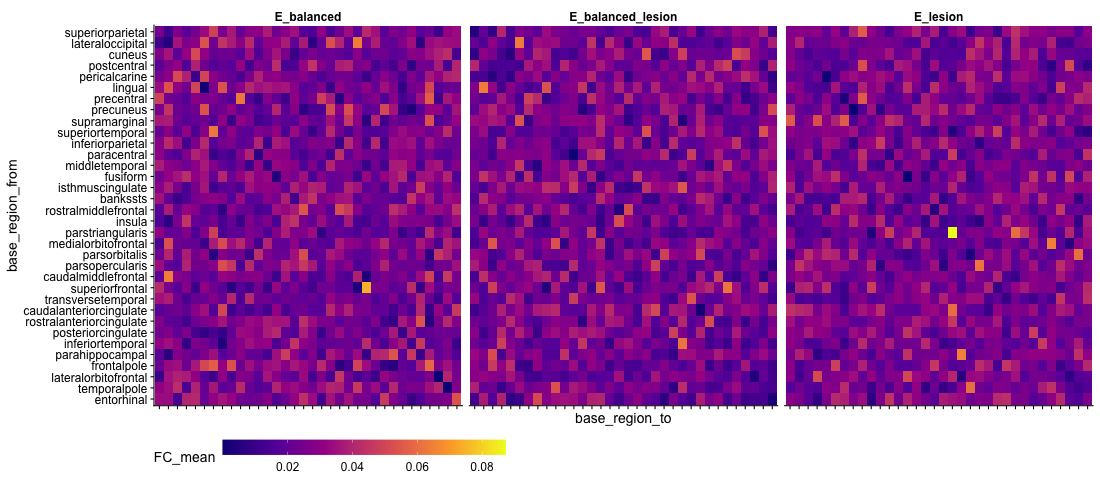

In [15]:
%%R -i SPI_results,region_order -w 1100

SPI_results %>% 
    filter(!is.na(value)) %>%
    group_by(base_region_from, base_region_to, TS_Type) %>% 
    summarise(FC_mean = mean(abs(value), na.rm=T)) %>%
    ungroup() %>%
    mutate(base_region_from = factor(base_region_from, levels=region_order),
           base_region_to = factor(base_region_to, levels=region_order)) %>%
    ggplot(mapping=aes(y=base_region_from, x=base_region_to)) +
    geom_tile(aes(fill=FC_mean)) +
    scale_x_discrete(limits=rev) +
    facet_wrap(TS_Type~., scales='free_x') +
    scale_fill_viridis_c(option='plasma') +
    theme(legend.position='bottom',
          axis.text.x = element_blank(),
          legend.key.width=unit(2, "cm"),
          strip.background = element_blank(),
          strip.text = element_text(face='bold'))